In [10]:
'''
Max Boving

ISTA 350 final project

11/01/2025

'''
import re
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [11]:
HEADERS = {"User-Agent": "UA-Student-Scraper/1.0 (contact: you@example.com)"}

soc_code_re = re.compile(r"^\d{2}-\d{4}$")

def to_num(s: str):
    """Convert strings like '1,234', '$25.50', '1.5%' to float; return None for blanks/dashes; keep text if not numeric."""
    if s is None:
        return None
    s = s.replace(",", "").replace("$", "").replace("%", "").strip()
    if s in {"", "—", "–", "-"}:
        return None
    try:
        return float(s)
    except ValueError:
        return s

def norm(h: str):
    """Normalize header text to snake_case keys."""
    return (h.lower()
              .replace("(", "")
              .replace(")", "")
              .replace("/", "_")
              .replace(",", "")
              .replace(" ", "_"))

def fetch_html(url, headers=HEADERS, timeout=20, retries=3, pause=1.0):
    """Fetch with simple retries."""
    last_err = None
    for _ in range(retries):
        try:
            r = requests.get(url, headers=headers, timeout=timeout)
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            time.sleep(pause)
    raise last_err


In [23]:
# Cell 2: Scrape one year (robust title capture)

def find_table_by_soc(soup: BeautifulSoup):
    for tbl in soup.find_all("table"):
        for tr in tbl.find_all("tr"):
            tds = tr.find_all(["td","th"])
            if len(tds) >= 2:
                a = tds[0].get_text(strip=True)
                b = tds[1].get_text(strip=True)
                if soc_code_re.match(a) or soc_code_re.match(b):
                    return tbl
    return None

def get_headers_and_index(rows):
    """
    Return (keys, col_index) where:
      - keys is a list of normalized header names
      - col_index is a dict mapping semantic names to column indices
    If a header row is missing, returns a positional fallback.
    """
    # Try to find a header row that mentions 'Occupation'
    header_cells = None
    for tr in rows[:5]:
        cells = [c.get_text(" ", strip=True) for c in tr.find_all(["th", "td"])]
        if cells and any("Occupation" in x for x in cells):
            header_cells = cells
            break

    if header_cells:
        keys = [norm(h) for h in header_cells]
        # Map important columns by fuzzy search on keys
        def find_col(*needle_parts):
            for idx, k in enumerate(keys):
                if all(part in k for part in needle_parts):
                    return idx
            return None

        col_index = {
            "code": find_col("occupation", "code"),
            "title": find_col("occupation", "title"),
            "employment": find_col("employment"),
            "employment_rse": find_col("employment", "rse"),
            "employment_per_1,000_jobs": find_col("per_1,000"),
            "median_hourly_wage": find_col("median", "hourly", "wage"),
            "mean_hourly_wage": find_col("mean", "hourly", "wage"),
            "annual_mean_wage": find_col("annual", "mean", "wage"),
            "mean_wage_rse": find_col("mean", "wage", "rse"),
        }
        return keys, col_index

    # Fallback when no real header row is present
    fallback_headers = [
        "Occupation code",
        "Occupation title",
        "Level",
        "Employment",
        "Employment RSE",
        "Employment per 1,000 jobs",
        "Median hourly wage",
        "Mean hourly wage",
        "Annual mean wage",
        "Mean wage RSE",
    ]
    keys = [norm(h) for h in fallback_headers]
    col_index = {
        "code": 0,
        "title": 1,
        "employment": 3,
        "employment_rse": 4,
        "employment_per_1,000_jobs": 5,
        "median_hourly_wage": 6,
        "mean_hourly_wage": 7,
        "annual_mean_wage": 8,
        "mean_wage_rse": 9,
    }
    return keys, col_index

def scrape_oews_year(year: int, pause: float = 0.8) -> pd.DataFrame:
    url = f"https://www.bls.gov/oes/{year}/may/oes_nat.htm"
    html = fetch_html(url)
    soup = BeautifulSoup(html, "html.parser")

    tbl = find_table_by_soc(soup)
    if tbl is None:
        raise RuntimeError(f"Could not locate the OEWS national table for {year}.")

    rows = tbl.find_all("tr")
    keys, col_index = get_headers_and_index(rows)

    def safe_cell_text(tds, idx):
        if idx is None or idx >= len(tds):
            return None
        # prefer link text if present (titles are often links)
        a = tds[idx].find("a")
        if a and a.get_text(strip=True):
            return a.get_text(" ", strip=True)
        return tds[idx].get_text(" ", strip=True)

    records = []
    for tr in rows:
        tds = tr.find_all(["td","th"])
        if len(tds) < 2:
            continue

        # Find SOC code position in this row
        code_idx = None
        for i, td in enumerate(tds[:3]):  # code is early in the row
            if soc_code_re.match(td.get_text(strip=True)):
                code_idx = i
                break
        if code_idx is None:
            continue  # not a data row

        # Prefer header-based title index; else default to cell right after the code
        title_idx = col_index.get("title")
        if title_idx is None or title_idx >= len(tds):
            title_idx = code_idx + 1 if code_idx + 1 < len(tds) else None

        occ_code = tds[code_idx].get_text(strip=True)
        occ_title = safe_cell_text(tds, title_idx)

        # Skip group headers/totals and blanks
        if not occ_title or occ_title.startswith(("Major", "Detailed", "Total")):
            continue

        row = {
            "occupation_code": occ_code,
            "occupation_title": occ_title,
        }

        # Pull numeric fields using header indices if available; else positional heuristics
        def get_num(name, fallback_idx=None):
            idx = col_index.get(name, fallback_idx)
            val = safe_cell_text(tds, idx)
            return to_num(val) if val is not None else None

        row["employment"] = get_num("employment", fallback_idx=code_idx + 3)
        row["employment_rse"] = get_num("employment_rse")
        row["employment_per_1,000_jobs"] = get_num("employment_per_1,000_jobs")
        row["median_hourly_wage"] = get_num("median_hourly_wage", fallback_idx=code_idx + 6)
        row["mean_hourly_wage"] = get_num("mean_hourly_wage")
        row["annual_mean_wage"] = get_num("annual_mean_wage")
        row["mean_wage_rse"] = get_num("mean_wage_rse")

        row["year"] = year
        records.append(row)

    time.sleep(pause)
    return pd.DataFrame(records)


In [24]:
# Cell 3: Scrape 2019–2023 and combine

YEARS = [2019, 2020, 2021, 2022, 2023]  # adjust if you need a different window

dfs = []
for y in YEARS:
    try:
        dfy = scrape_oews_year(y)
        dfs.append(dfy)
        print(f"Scraped {y}: {dfy.shape}")
    except Exception as e:
        print(f"Failed {y}: {e}")

df_all = pd.concat(dfs, ignore_index=True)
print("\nCombined:", df_all.shape)
df_all.head(10)


Scraped 2019: (1040, 10)
Scraped 2020: (1040, 10)
Scraped 2021: (1105, 10)
Scraped 2022: (1104, 10)
Scraped 2023: (1105, 10)

Combined: (5394, 10)


,occupation_code,occupation_title,employment,employment_rse,"employment_per_1,000_jobs",median_hourly_wage,mean_hourly_wage,annual_mean_wage,mean_wage_rse,year
0,00-0000,All Occupations,146875480.0,0.1,None,19.14,25.72,53490.0,0.1,2019
1,11-0000,Management Occupations,8054120.0,0.2,None,50.8,58.88,122480.0,0.1,2019
2,11-1000,Top Executives,2658440.0,0.3,None,49.63,61.09,127070.0,0.2,2019
3,11-1011,Chief Executives,205890.0,0.8,None,88.68,93.2,193850.0,0.4,2019
4,11-1021,General and Operations Managers,2400280.0,0.3,None,48.45,59.15,123030.0,0.2,2019
5,11-1031,Legislators,52280.0,2.2,None,(4),(4),49440.0,1.3,2019
6,11-2000,"Advertising, Marketing, Promotions, Public Rel...",770540.0,0.5,None,61.96,68.91,143330.0,0.2,2019
7,11-2011,Advertising and Promotions Managers,25100.0,3.0,None,60.34,68.22,141890.0,1.3,2019
8,11-2020,Marketing and Sales Managers,666280.0,0.5,None,62.84,69.55,144660.0,0.2,2019
9,11-2021,Marketing Managers,263680.0,0.8,None,65.79,71.73,149200.0,0.3,2019


In [26]:

# Ensure core columns exist even if headers vary slightly
for col in ["occupation_code", "occupation_title"]:
    if col not in df_all.columns:
        df_all[col] = None

numeric_cols = [
    "employment", "employment_rse",
    "employment_per_1,000_jobs",
    "median_hourly_wage", "mean_hourly_wage",
    "annual_mean_wage", "mean_wage_rse",
]
for c in numeric_cols:
    if c in df_all.columns:
        df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

order = ["year", "occupation_code", "occupation_title"] + [c for c in numeric_cols if c in df_all.columns]
df_all = df_all.loc[:, [c for c in order if c in df_all.columns]]

df_all.sample(5, random_state=0)


,year,occupation_code,occupation_title,employment,employment_rse,"employment_per_1,000_jobs",median_hourly_wage,mean_hourly_wage,annual_mean_wage,mean_wage_rse
4358,2023,13-1141,"Compensation, Benefits, and Job Analysis Speci...",99850.0,1.3,NaN,35.83,38.76,80620.0,0.9
3801,2022,39-4010,Embalmers and Crematory Operators,6880.0,4.9,NaN,22.25,23.77,49440.0,1.8
4430,2023,17-2121,Marine Engineers and Naval Architects,9960.0,7.4,NaN,48.21,51.98,108110.0,1.8
142,2019,17-3025,Environmental Engineering Technologists and Te...,18010.0,4.5,NaN,24.34,26.32,54740.0,1.1
2370,2021,25-1064,"Geography Teachers, Postsecondary",3440.0,0.6,NaN,NaN,NaN,88150.0,0.4


In [27]:
codes_by_year = {y: set(df_all.loc[df_all["year"]==y, "occupation_code"]) for y in YEARS}
common_codes = set.intersection(*codes_by_year.values())
len(common_codes)

df_common = df_all[df_all["occupation_code"].isin(common_codes)].copy()
df_common

,year,occupation_code,occupation_title,employment,employment_rse,"employment_per_1,000_jobs",median_hourly_wage,mean_hourly_wage,annual_mean_wage,mean_wage_rse
0,2019,00-0000,All Occupations,146875480.0,0.1,NaN,19.14,25.72,53490.0,0.1
1,2019,11-0000,Management Occupations,8054120.0,0.2,NaN,50.80,58.88,122480.0,0.1
2,2019,11-1000,Top Executives,2658440.0,0.3,NaN,49.63,61.09,127070.0,0.2
3,2019,11-1011,Chief Executives,205890.0,0.8,NaN,88.68,93.20,193850.0,0.4
4,2019,11-1021,General and Operations Managers,2400280.0,0.3,NaN,48.45,59.15,123030.0,0.2
...,...,...,...,...,...,...,...,...,...,...
5389,2023,53-7072,"Pump Operators, Except Wellhead Pumpers",11570.0,5.5,NaN,26.29,28.20,58650.0,2.0
5390,2023,53-7073,Wellhead Pumpers,18230.0,6.2,NaN,34.53,33.62,69930.0,1.6
5391,2023,53-7081,Refuse and Recyclable Material Collectors,135430.0,1.3,NaN,22.00,22.99,47810.0,0.7
5392,2023,53-7121,"Tank Car, Truck, and Ship Loaders",11400.0,4.7,NaN,28.18,29.10,60530.0,1.5


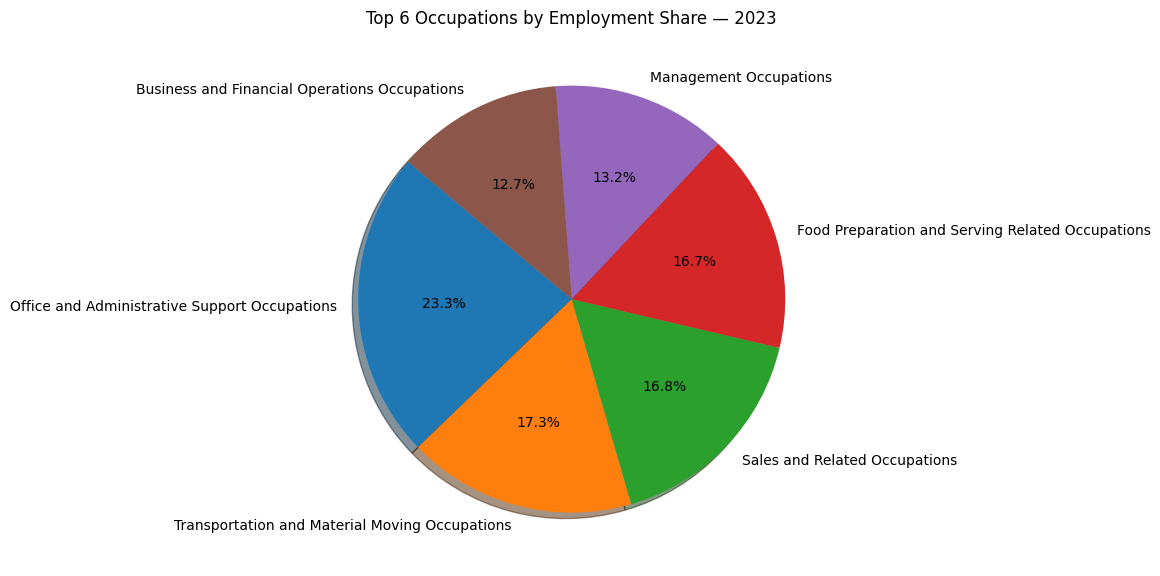

In [44]:
year = 2023  
df_year = df_common[df_common["year"] == year].dropna(subset=["employment"])

top6 = (
    df_year[df_year["occupation_title"] != "All Occupations"]
    .nlargest(6, "employment")
    .copy()
)

# calculate shares
top6["share"] = top6["employment"] / top6["employment"].sum() * 100

# create the pie
plt.figure(figsize=(10,8))
plt.pie(
    top6["employment"],
    labels=top6["occupation_title"],
    autopct="%1.1f%%",
    startangle=140,
)
plt.title(f"Top 6 Occupations by Employment Share — {year}")
plt.tight_layout()
plt.show()



/Users/maxboving/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/maxboving/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/maxboving/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/maxboving/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cat

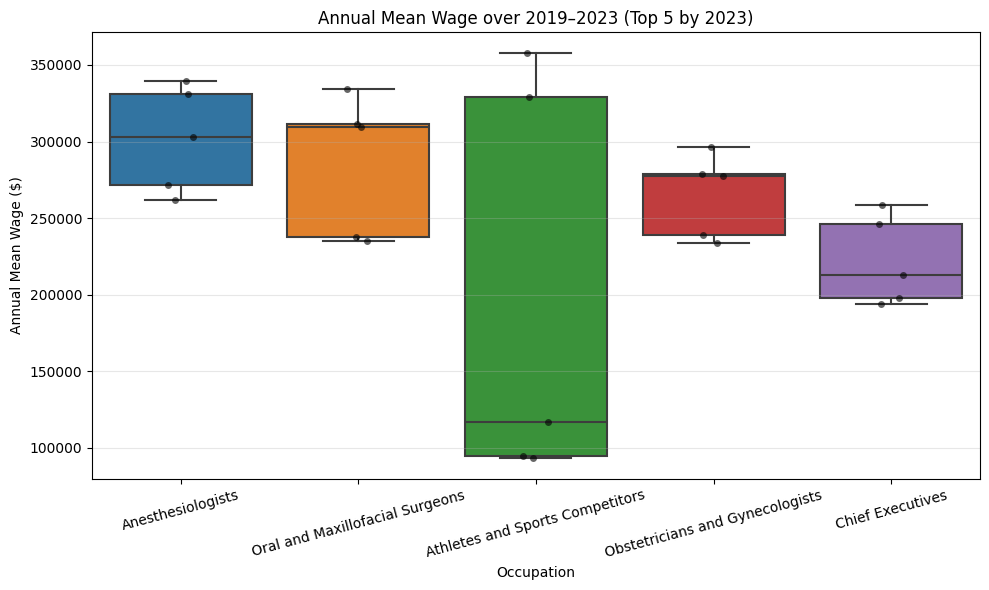

In [52]:
years_window = sorted(df_common["year"].unique())[-5:]   # last 5 years in your data
latest_year  = max(years_window)

top5_titles = (
    df_common[df_common["year"] == latest_year]
    .dropna(subset=["annual_mean_wage"])
    .nlargest(5, "annual_mean_wage")["occupation_title"]
    .tolist()
)

# subset to top5 over the chosen 5-year window
df_top5 = (
    df_common[
        df_common["occupation_title"].isin(top5_titles)
        & df_common["year"].isin(years_window)
    ]
    .dropna(subset=["annual_mean_wage"])
    .copy()
)

# order categories by latest-year ranking (highest first)
order = (
    df_common[df_common["year"] == latest_year]
    .set_index("occupation_title")
    .loc[top5_titles]["annual_mean_wage"]
    .sort_values(ascending=False)
    .index.tolist()
)
df_top5["occupation_title"] = pd.Categorical(df_top5["occupation_title"], categories=order, ordered=True)

# --- boxplot + points ---
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_top5,
    x="occupation_title",
    y="annual_mean_wage",
    fliersize=3
)
sns.stripplot(
    data=df_top5,
    x="occupation_title",
    y="annual_mean_wage",
    color="black",
    alpha=0.6,
    jitter=0.08
)

plt.title(f"Annual Mean Wage over {years_window[0]}–{years_window[-1]} (Top 5 by {latest_year})")
plt.xlabel("Occupation")
plt.ylabel("Annual Mean Wage ($)")
plt.xticks(rotation=15)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

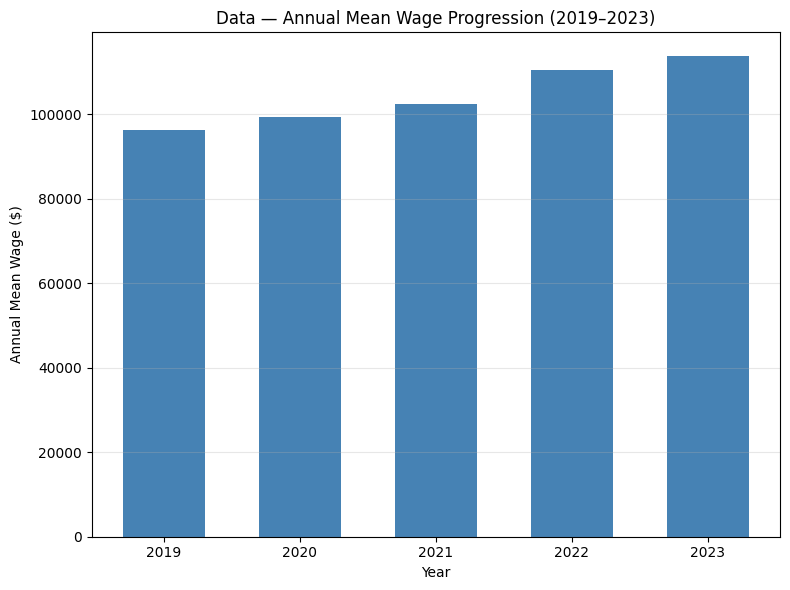

In [56]:
import matplotlib.pyplot as plt

occupation = "Data"

sub = (
    df_common[df_common["occupation_title"].str.contains(occupation, case=False, na=False)]
    .sort_values("year")
)
plt.figure(figsize=(8,6))
plt.bar(sub["year"].astype(int), sub["annual_mean_wage"], color="steelblue", width=0.6)

plt.title(f"{occupation} — Annual Mean Wage Progression (2019–2023)")
plt.xlabel("Year")
plt.ylabel("Annual Mean Wage ($)")
plt.xticks(sorted(sub["year"].unique()))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()